In [1]:
%load_ext autoreload
%autoreload 2
import helper_methods_for_aggregate_data_analysis as helper
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from covid_constants_and_util import *
from scipy.stats import pearsonr, linregress
from model_experiments import *
import os

Setting numpy cores to 1
Running code on rambo.stanford.edu; at Stanford=True


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
FIGURES_DIRECTORY = './covid_figures_for_paper/'

## Load data: Google, SafeGraph POI, ACS

In [3]:
# Static variables
# Google method: "The baseline is the median value, for the corresponding day of the week, 
# during the 5-week period Jan 3–Feb 6, 2020."
# note: Jan 3 is a Friday
BASELINE_DATES = helper.list_datetimes_in_range(datetime.datetime(2020, 1, 3), datetime.datetime(2020, 2, 6))
# Feb 28 bc this is the closest Friday to Mar 1, the start of our modeling
# May 2 bc this is as far as the Google and SafeGraph data go
TEST_DATES = helper.list_datetimes_in_range(datetime.datetime(2020, 2, 28), datetime.datetime(2020, 5, 2))

GOOGLE_DATE_VALS = [dt.strftime('%Y-%m-%d') for dt in TEST_DATES]  # need to match these values in the 'date' column
POI_BASELINE_COLS = ['%s.%s.%s' % (dt.year, dt.month, dt.day) for dt in BASELINE_DATES]
POI_TEST_COLS = ['%s.%s.%s' % (dt.year, dt.month, dt.day) for dt in TEST_DATES]
SDM_BASELINE_COLS = ['%s.%s.%s_completely_home_device_count' % (dt.year, dt.month, dt.day) for dt in BASELINE_DATES]
SDM_TEST_COLS = ['%s.%s.%s_completely_home_device_count' % (dt.year, dt.month, dt.day) for dt in TEST_DATES]

assert(TEST_DATES[0].weekday() == BASELINE_DATES[0].weekday())

In [4]:
# Load Google mobility data
google_df = helper.load_google_mobility_data()
must_have_cols = ['date', 'sub_region_1']  # column for state
google_df = google_df.dropna(subset=must_have_cols)
google_df.columns

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [5]:
google_dates = google_df.date.unique()
print(min(google_dates))
print(max(google_dates))

2020-02-15
2020-05-02


In [7]:
# load SafeGraph POI data
must_have_cols = POI_BASELINE_COLS + POI_TEST_COLS + ['sub_category', 'region']  # necessary 
may_have_cols = must_have_cols + ['top_category', 'location_name']  # nice to have
chunks = helper.load_multiple_chunks(range(5), cols=may_have_cols)
chunks = chunks.dropna(subset=must_have_cols)

Reading chunk 0 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 0 in 19.448 seconds
Reading chunk 1 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 1 in 21.538 seconds
Reading chunk 2 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 2 in 20.179 seconds
Reading chunk 3 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 3 in 21.501 seconds
Reading chunk 4 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annota

In [8]:
# load SafeGraph Social Distancing Metrics data
baseline_sdm = helper.load_social_distancing_metrics(BASELINE_DATES)
must_have_cols = ['census_block_group'] + SDM_BASELINE_COLS
baseline_sdm = baseline_sdm.dropna(subset=must_have_cols)

test_sdm = helper.load_social_distancing_metrics(TEST_DATES)
must_have_cols = ['census_block_group'] + SDM_TEST_COLS
test_sdm = test_sdm.dropna(subset=must_have_cols)

sdm_data = baseline_sdm.join(test_sdm.set_index('census_block_group'), on='census_block_group', how='inner')
sdm_data.head()

Loading social distancing metrics for 35 datetimes; using version v2
Total time to load social distancing metrics: 165.675 seconds; total rows 219731
Loading social distancing metrics for 65 datetimes; using version v2
Total time to load social distancing metrics: 262.212 seconds; total rows 219849


,census_block_group,2020.1.3_device_count,2020.1.3_distance_traveled_from_home,2020.1.3_completely_home_device_count,2020.1.3_full_time_work_behavior_devices,2020.1.4_device_count,2020.1.4_distance_traveled_from_home,2020.1.4_completely_home_device_count,2020.1.4_full_time_work_behavior_devices,2020.1.5_device_count,...,2020.4.30_completely_home_device_count,2020.4.30_full_time_work_behavior_devices,2020.5.1_device_count,2020.5.1_distance_traveled_from_home,2020.5.1_completely_home_device_count,2020.5.1_full_time_work_behavior_devices,2020.5.2_device_count,2020.5.2_distance_traveled_from_home,2020.5.2_completely_home_device_count,2020.5.2_full_time_work_behavior_devices
0,10139533002,58.0,19907.0,8.0,1.0,59.0,18999.0,9.0,1.0,59.0,...,8.0,1.0,53.0,14645.0,7.0,1.0,52.0,14606.0,11.0,1.0
1,10210601014,166.0,7639.0,31.0,14.0,159.0,20310.0,30.0,1.0,166.0,...,38.0,10.0,155.0,3548.0,28.0,4.0,142.0,5046.0,28.0,1.0
2,10950303005,81.0,9414.0,14.0,6.0,92.0,9323.0,8.0,1.0,84.0,...,21.0,2.0,96.0,9371.0,21.0,1.0,95.0,9252.0,16.0,1.0
3,11010055032,83.0,9012.0,17.0,1.0,82.0,6648.0,20.0,7.0,89.0,...,32.0,1.0,114.0,7338.0,32.0,3.0,100.0,5306.0,30.0,5.0
4,40210002061,505.0,14810.0,107.0,19.0,501.0,9414.0,141.0,10.0,505.0,...,159.0,24.0,494.0,8651.0,195.0,11.0,470.0,8304.0,162.0,7.0


In [9]:
# Load ACS data
acs_df = helper.load_and_reconcile_multiple_acs_data()
acs_df.head()

220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read


,census_block_group,total_cbg_population_2018_1YR,state_code,county_code,state_name,GEOID,p_black_2017_5YR,p_white_2017_5YR,p_asian_2017_5YR,median_household_income_2017_5YR,block_group_area_in_square_miles_2017_5YR,people_per_mile_2017_5YR,TRACTCE,Metropolitan/Micropolitan Statistical Area,CBSA Title,State Name,people_per_mile_hybrid
0,10010201001,636,01,1001,Alabama,15000US010010201001,0.037572,0.916185,0.000000,34907.0,1.651735,418.953424,20100.0,Metropolitan Statistical Area,"Montgomery, AL",Alabama,385.049679
1,10010201002,1287,01,1001,Alabama,15000US010010201002,0.060711,0.830876,0.019081,76875.0,2.149942,536.293534,20100.0,Metropolitan Statistical Area,"Montgomery, AL",Alabama,598.620796
2,10010202001,810,01,1001,Alabama,15000US010010202001,0.635294,0.332353,0.000000,24063.0,0.794749,1283.423916,20200.0,Metropolitan Statistical Area,"Montgomery, AL",Alabama,1019.189580
3,10010202002,1218,01,1001,Alabama,15000US010010202002,0.465278,0.490451,0.019097,48382.0,0.491497,2343.861068,20200.0,Metropolitan Statistical Area,"Montgomery, AL",Alabama,2478.144775
4,10010203001,2641,01,1001,Alabama,15000US010010203001,0.255577,0.590607,0.009785,55476.0,1.496373,1707.461531,20300.0,Metropolitan Statistical Area,"Montgomery, AL",Alabama,1764.933818


## Figure out category mapping

In [58]:
# top 10 most common sub categories
chunks.groupby('sub_category').size().sort_values(ascending=False)[:10]

sub_category
Full-Service Restaurants                                      357128
Limited-Service Restaurants                                   118887
Religious Organizations                                       113950
Gasoline Stations with Convenience Stores                     104097
Fitness and Recreational Sports Centers                        96441
Elementary and Secondary Schools                               85311
Snack and Nonalcoholic Beverage Bars                           81330
Nature Parks and Other Similar Institutions                    74130
Supermarkets and Other Grocery (except Convenience) Stores     70565
Child Day Care Services                                        68296
dtype: int64

In [59]:
# find sub_category types by searching for key words
sub_categories = list(chunks['sub_category'].unique())
[c for c in sub_categories if type(c)==str and 'transit' in c.lower()]

['All Other Transit and Ground Passenger Transportation']

In [68]:
# find sub_category types by examples of POIs
pois = chunks[(chunks['location_name'].str.contains('Union Square')) & (chunks['location_name'].str.contains('123')) & (chunks['sub_category'] != 'Full-Service Restaurants')]
pois.head(100)[['location_name', 'sub_category']]

,location_name,sub_category
safegraph_place_id,,


In [69]:
# mapping of Google category to SafeGraph sub_category (more specific than top_category)
# see https://www.google.com/covid19/mobility/data_documentation.html for descriptions 
# of what each Google category means
# see https://www.naics.com/naics-code-description for descriptions of what the SafeGraph
# (aka NAICS) categories mean
CATEGORY_MAPPING = {
    # from Google: "restaurants, cafes, shopping centers, theme parks, museums, libraries, 
    # and movie theaters"
    'Retail & recreation':['Full-Service Restaurants',
                           'Limited-Service Restaurants',  # e.g. Subway
                           'Snack and Nonalcoholic Beverage Bars',  # e.g. cafes, juiceries
                           'Drinking Places (Alcoholic Beverages)',  # bars
                           'Malls',  # shopping centers
                           'Amusement and Theme Parks',
                           'Museums',
                           'Libraries and Archives',
                           'Motion Picture Theaters (except Drive-Ins)'],
    
     # from Google: "grocery markets, food warehouses, farmers markets, specialty food shops, 
     # drug stores, and pharmacies"
     'Grocery & pharmacy':['Supermarkets and Other Grocery (except Convenience) Stores',
                           'Food (Health) Supplement Stores',
                           'Fish and Seafood Markets',
                           'All Other Specialty Food Stores',
                           'Pharmacies and Drug Stores'],
    
     # from Google: "local parks, national parks, public beaches, marinas, dog parks, 
     # plazas, and public gardens"
     'Parks':['Nature Parks and Other Similar Institutions'],  # includes parks, beaches, gardens 
}

GOOGLE_CATEGORIES = ['Retail & recreation', 'Grocery & pharmacy', 'Parks', 'Residential']

In [70]:
# considered, but removed
removed = ['Personal Care Services', # saunas, tanning salons, ear piercing services
           'Home Health Care Services', # skilled nursing services in the home
           'Miscellaneous Nondurable Goods Merchant Wholesalers',  # merchant wholesale distribution e.g pet supplies, christmas trees
           'Miscellaneous Durable Goods Merchant Wholesalers', 
           'Warehousing and Storage', # seems less focused on food
           'Drugs and Druggists\' Sundries Merchant Wholesalers',  # I've decided to exclude wholesalers          
]
stores = ['Sporting Goods, Hobby, and Musical Instrument Stores',
          'Clothing Stores',
          'Automotive Parts, Accessories, and Tire Stores',
          'Other Miscellaneous Store Retailers',
          'Furniture Stores',
          'Office Supplies, Stationery, and Gift Stores',
          'Jewelry, Luggage, and Leather Goods Stores',
          'Beer, Wine, and Liquor Stores',
          'Book Stores and News Dealers',
          'Shoe Stores']

In [71]:
# check how much each category contributes to overall POI visits
baseline_sum = np.sum(chunks[POI_BASELINE_COLS].values)
y = []
for category in CATEGORY_MAPPING:
    sub_categories = set(CATEGORY_MAPPING[category])
    pois = chunks[chunks['sub_category'].isin(sub_categories)]
    print('Found %d POIs in category %s' % (len(pois), category))
    category_sum = np.sum(pois[POI_BASELINE_COLS].values)  # sum over POIs
    y.append(category_sum / baseline_sum)
y

Found 611997 POIs in category Retail & recreation
Found 112114 POIs in category Grocery & pharmacy
Found 74130 POIs in category Parks


[0.34801274184273173, 0.055763479125853936, 0.025878149513024747]

## 1. Compare trends within one state, over days

In [72]:
def get_google_trend_for_state(df, state, category=None,
                               make_plot=False, ax=None, color=None):
    if category is not None:
        assert category in GOOGLE_CATEGORIES
        if category == 'Retail & recreation':
            cols = 'retail_and_recreation_percent_change_from_baseline'
        elif category == 'Grocery & pharmacy':
            cols = 'grocery_and_pharmacy_percent_change_from_baseline'
        elif category == 'Parks':
            cols = 'parks_percent_change_from_baseline'
        else:
            cols = 'residential_percent_change_from_baseline'
    else:
        cols = ['retail_and_recreation_percent_change_from_baseline',
                'grocery_and_pharmacy_percent_change_from_baseline',
                'parks_percent_change_from_baseline',
                'residential_percent_change_from_baseline']
            
    state_df = df[(df['sub_region_1'] == state) & (df['sub_region_2'].isnull())]
    state_df = state_df[state_df['date'].isin(set(GOOGLE_DATE_VALS))]
    if len(state_df) != len(TEST_DATES):
        print('Missing dates in Google data for %s: found %d rows, wanted %d' % 
              (state, len(state_df), len(TEST_DATES)))
        return None
    state_df = state_df.sort_values(by='date')
    y = state_df[cols].values  # either 1D or 2D; length is dates
    
    if make_plot:
        assert(category is not None and ax is not None and color is not None)
        smoothed_y = apply_smoothing(y)
        ax.plot_date(TEST_DATES, smoothed_y, linestyle='-', marker='.', color=color)
        ax.fill_between(TEST_DATES, 0, smoothed_y, alpha=0.3, color=color)
        if category == 'Residential':
            ax.set_ylim(-50, 150)
        else:
            ax.set_ylim(-80, 80)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.grid(alpha=0.5)
        ax.set_title('%s (Google data)' % category)
    return y

(65, 4)


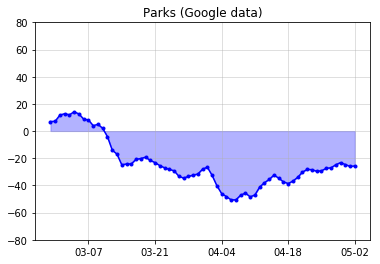

In [73]:
fig, ax = plt.subplots()
y = get_google_trend_for_state(google_df, 'California', category='Parks', make_plot=True, ax=ax, color='blue')
y_mat = get_google_trend_for_state(google_df, 'California')
print(y_mat.shape)

In [74]:
def compute_percent_change_trend(df, baseline_cols, test_cols):
    baseline_vals = np.sum(df[baseline_cols].values, axis=0)  # sum over POIs or CBGs -> 1 x num_days
    baseline_week = []
    # iterate through the days of the week, 0=first day of baseline cols (a Friday)
    for i in range(7):
        day_idxs = np.arange(i, len(baseline_cols), 7)
        median = np.median(baseline_vals[day_idxs])
        baseline_week.append(median)        
    test_vals = np.sum(df[test_cols].values, axis=0)
    y = []
    for i, v in enumerate(test_vals):
        baseline = baseline_week[i % 7]
        diff = v - baseline
        y.append(100. * diff / baseline)
    return np.array(y)

In [104]:
def get_safegraph_poi_trend_for_state(df, state, category=None,
                                      make_plot=False, ax=None, color=None,
                                      verbose=True):
    if category is not None:
        assert category in CATEGORY_MAPPING
        sub_categories = set(CATEGORY_MAPPING[category])
        state_df = df[(df['region'] == state) & (df['sub_category']).isin(sub_categories)]
        if verbose: 
            print('Found %d POIs in state %s and category %s' % (len(state_df), state, category))
    else:
        state_df = df[df['region'] == state]
        if verbose: 
            print('Found %d POIs in state %s' % (len(state_df), state))
    if len(state_df) == 0:
        return None
    
    y = compute_percent_change_trend(df, POI_BASELINE_COLS, POI_TEST_COLS)
    if make_plot:
        assert(ax is not None and color is not None)
        smoothed_y = apply_smoothing(y)
        ax.plot_date(TEST_DATES, smoothed_y, linestyle='-', marker='.', color=color)
        ax.fill_between(TEST_DATES, 0, smoothed_y, alpha=0.3, color=color)
        ax.set_ylim(-80, 80)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.grid(alpha=0.5)
        if category is None:
            ax.set_title('All POIs in state')
        else:
            ax.set_title('%s (SafeGraph data)' % category)
    return y

Found 8639 POIs in state CA and category Parks
Found 281691 POIs in state CA


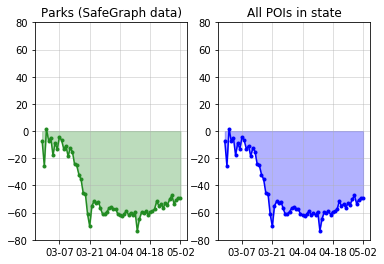

In [102]:
fig, axes = plt.subplots(1,2)
y = get_safegraph_poi_trend_for_state(chunks, 'CA', category='Parks', make_plot=True, ax=axes[0], color='forestgreen')
y_mat = get_safegraph_poi_trend_for_state(chunks, 'CA', make_plot=True, ax=axes[1], color='blue')

In [77]:
def get_safegraph_at_home_trend_for_state(sdm_df, acs_df, state,
                                          make_plot=False, ax=None, color=None,
                                          verbose=True):
    cbgs_in_state = set(acs_df[acs_df['state_name'] == state].census_block_group.values)
    state_df = sdm_df[sdm_df['census_block_group'].isin(cbgs_in_state)]
    if verbose:
        print('Found %d out of %d CBGs in state %s' % (len(state_df), len(cbgs_in_state), state))
    if len(state_df) == 0:
        return None
    y = compute_percent_change_trend(state_df, SDM_BASELINE_COLS, SDM_TEST_COLS)
    if make_plot:
        assert(ax is not None and color is not None)
        smoothed_y = apply_smoothing(y)
        ax.plot_date(TEST_DATES, smoothed_y, linestyle='-', marker='.', color=color)
        ax.fill_between(TEST_DATES, 0, smoothed_y, alpha=0.3, color=color)
        ax.set_ylim(-50, 150)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.grid(alpha=0.5)
        ax.set_title('Completely at home (SafeGraph Data)')
    return y

Found 22984 out of 23212 CBGs in state California


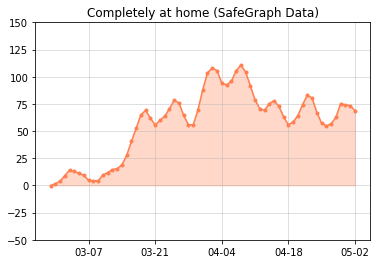

In [78]:
fig, ax = plt.subplots()
y = get_safegraph_at_home_trend_for_state(sdm_data, acs_df, 'California', make_plot=True, ax=ax, color='coral')

In [79]:
def compare_plots_for_state(state, categories=None):
    assert state in codes_to_states
    if categories is None:
        categories = GOOGLE_CATEGORIES
    state_name = codes_to_states[state]
    n = len(categories)
    fig = plt.figure(figsize=(5*n, 8))
    colors = ['royalblue', 'coral', 'forestgreen', 'darkorchid']
    ax_idx = 1
    for i, category in enumerate(categories):
        ax = fig.add_subplot(2, n, i+1)
        ax_idx += 1
        google_state_name = 'District of Columbia' if state_name == 'Washington, D.C.' else state_name
        google_v = get_google_trend_for_state(google_df, google_state_name, category=category,
                                              make_plot=True, ax=ax, color=colors[i])
        ax = fig.add_subplot(2, n, i+1+n)
        ax_idx += 1
        if category == 'Residential':
            safegraph_v = get_safegraph_at_home_trend_for_state(sdm_data, acs_df, state_name,
                                                                make_plot=True, ax=ax, color=colors[i])
        else:
            safegraph_v = get_safegraph_poi_trend_for_state(chunks, state, category=category,
                                                            make_plot=True, ax=ax, color=colors[i])
        if google_v is not None and safegraph_v is not None:
            nan_idx = np.isnan(google_v)
            print('Num nan in Google data:', np.sum(nan_idx))
            google_v = google_v[~nan_idx]
            safegraph_v = safegraph_v[~nan_idx]
            r, p = pearsonr(google_v, safegraph_v)
            print('%s: pearson r=%.2f, p=%.4f' % (category, r, p))
            slope, intercept, r_value, _, _ = linregress(safegraph_v, google_v)
            print('%s: slope=%.2f, intercept=%.2f, r^2=%.2f' % (category, slope, intercept, r_value**2))
    fig.suptitle(state_name.upper(), fontsize=20)

Found 76634 POIs in state CA and category Retail & recreation
Num nan in Google data: 0
Retail & recreation: pearson r=0.95, p=0.0000
Retail & recreation: slope=1.03, intercept=11.95, r^2=0.90
Found 13099 POIs in state CA and category Grocery & pharmacy
Num nan in Google data: 0
Grocery & pharmacy: pearson r=0.83, p=0.0000
Grocery & pharmacy: slope=0.56, intercept=16.01, r^2=0.70
Found 8639 POIs in state CA and category Parks
Num nan in Google data: 0
Parks: pearson r=0.82, p=0.0000
Parks: slope=0.79, intercept=11.45, r^2=0.68
Found 22984 out of 23212 CBGs in state California
Num nan in Google data: 0
Residential: pearson r=0.88, p=0.0000
Residential: slope=0.20, intercept=3.35, r^2=0.77


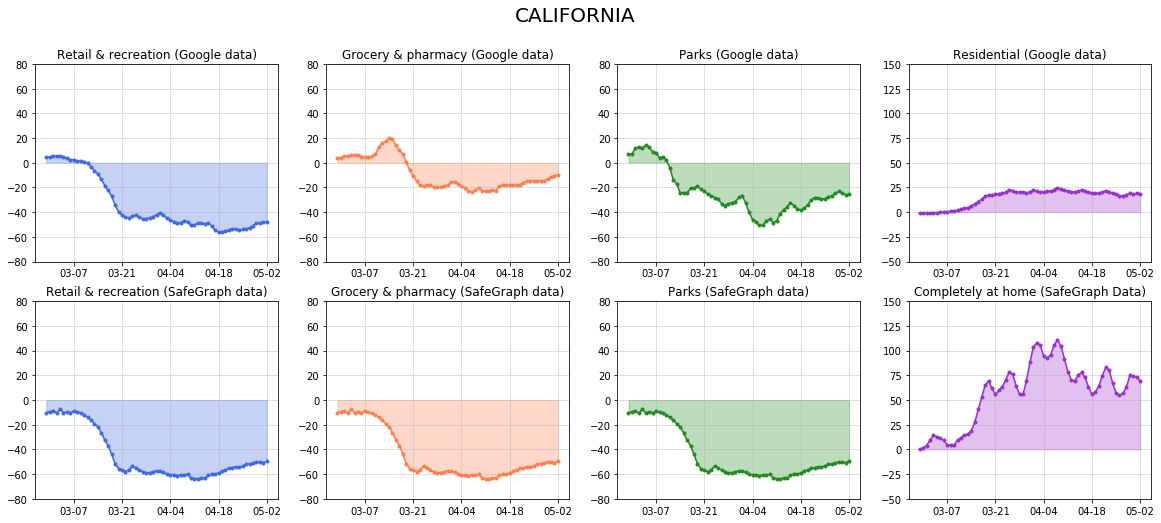

In [80]:
compare_plots_for_state('CA')

Found 40234 POIs in state NY and category Retail & recreation
Num nan in Google data: 0
Retail & recreation: pearson r=0.96, p=0.0000
Retail & recreation: slope=1.28, intercept=16.69, r^2=0.92
Found 7399 POIs in state NY and category Grocery & pharmacy
Num nan in Google data: 0
Grocery & pharmacy: pearson r=0.76, p=0.0000
Grocery & pharmacy: slope=0.63, intercept=17.51, r^2=0.58
Found 3556 POIs in state NY and category Parks
Num nan in Google data: 0
Parks: pearson r=0.57, p=0.0000
Parks: slope=0.82, intercept=24.27, r^2=0.32
Found 14998 out of 15463 CBGs in state New York
Num nan in Google data: 0
Residential: pearson r=0.91, p=0.0000
Residential: slope=0.21, intercept=2.92, r^2=0.83


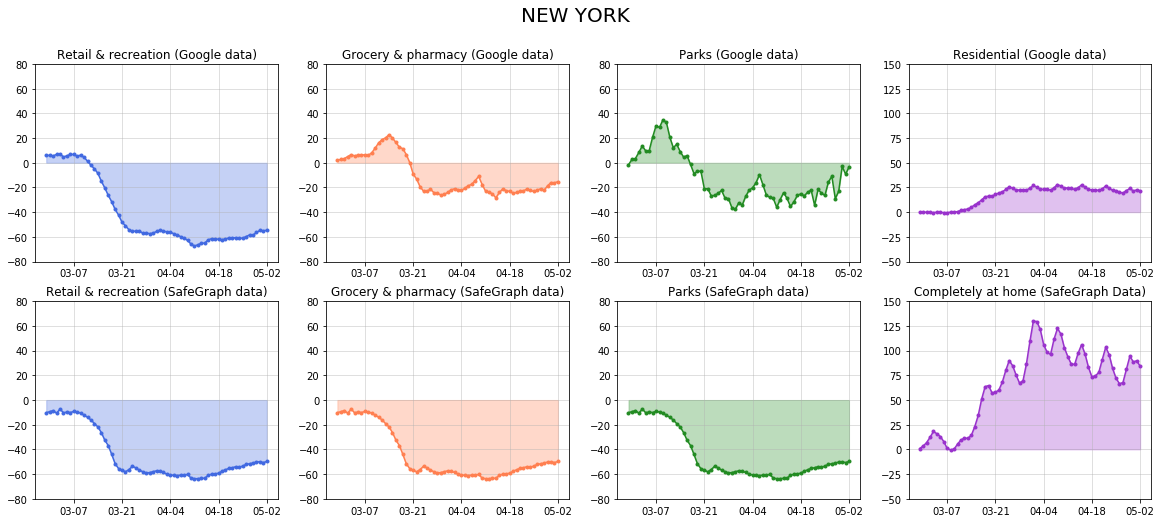

In [105]:
compare_plots_for_state('NY')
fn = os.path.join(FIGURES_DIRECTORY, 'safegraph_google_comparison_ny.pdf')
plt.savefig(fn, dpi=300, bbox_inches='tight')

Found 1492 POIs in state SD and category Retail & recreation
Num nan in Google data: 0
Retail & recreation: pearson r=0.93, p=0.0000
Retail & recreation: slope=0.90, intercept=18.64, r^2=0.87
Found 324 POIs in state SD and category Grocery & pharmacy
Num nan in Google data: 0
Grocery & pharmacy: pearson r=0.69, p=0.0000
Grocery & pharmacy: slope=0.41, intercept=22.50, r^2=0.48
Found 199 POIs in state SD and category Parks
Num nan in Google data: 0
Parks: pearson r=-0.13, p=0.3190
Parks: slope=-0.31, intercept=28.57, r^2=0.02
Found 652 out of 654 CBGs in state South Dakota
Num nan in Google data: 0
Residential: pearson r=0.82, p=0.0000
Residential: slope=0.18, intercept=3.65, r^2=0.67


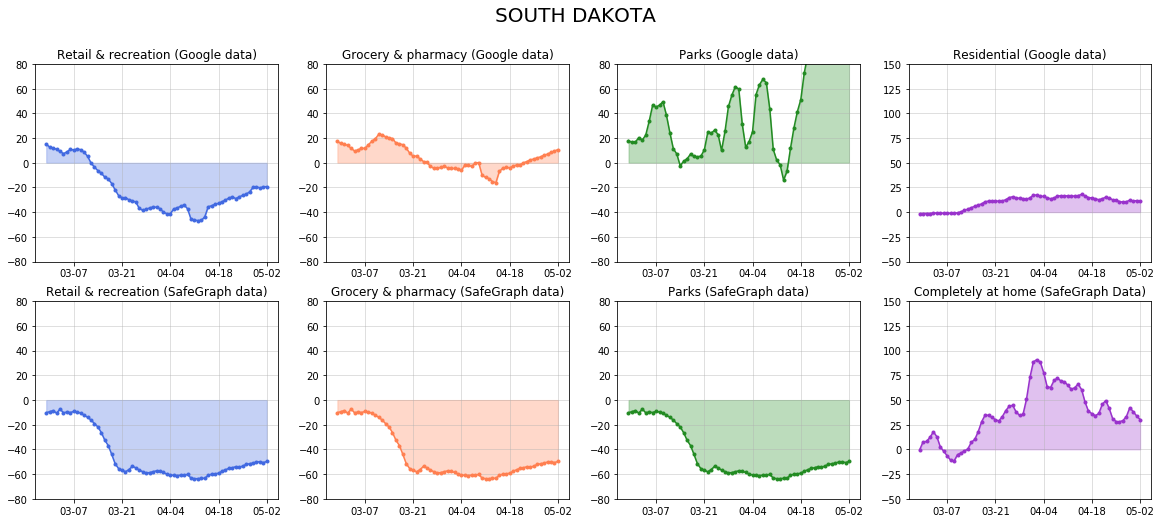

In [82]:
compare_plots_for_state('SD')

Found 1760 POIs in state DE and category Retail & recreation
Num nan in Google data: 0
Retail & recreation: pearson r=0.96, p=0.0000
Retail & recreation: slope=1.00, intercept=19.14, r^2=0.92
Found 348 POIs in state DE and category Grocery & pharmacy
Num nan in Google data: 0
Grocery & pharmacy: pearson r=0.85, p=0.0000
Grocery & pharmacy: slope=0.57, intercept=14.33, r^2=0.72
Found 102 POIs in state DE and category Parks
Num nan in Google data: 2
Parks: pearson r=0.37, p=0.0032
Parks: slope=0.56, intercept=34.38, r^2=0.13
Found 554 out of 574 CBGs in state Delaware
Num nan in Google data: 0
Residential: pearson r=0.86, p=0.0000
Residential: slope=0.21, intercept=1.53, r^2=0.73


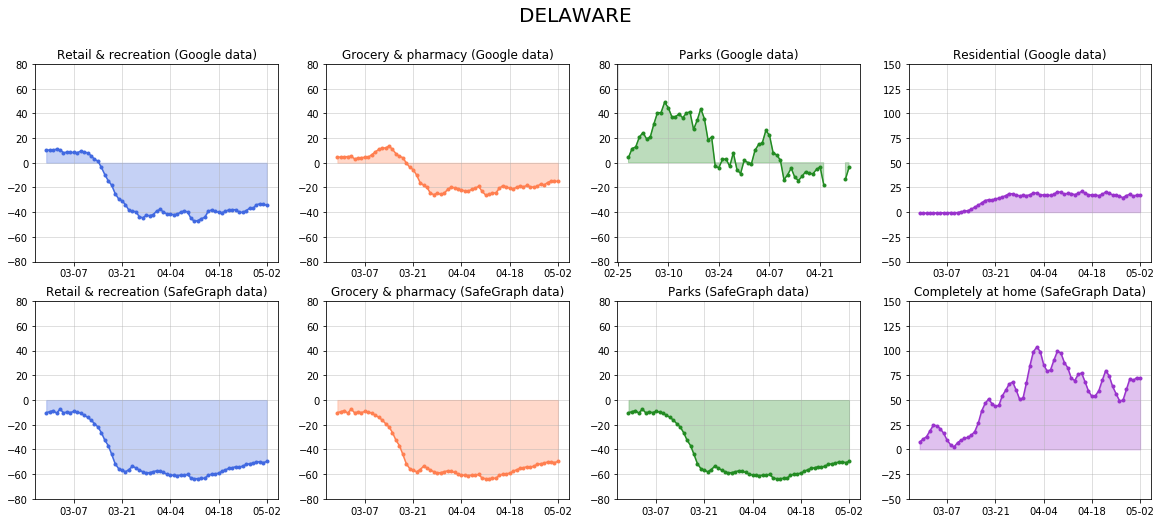

In [83]:
compare_plots_for_state('DE')

In [84]:
def compare_timeseries_for_all_states():
    all_results = []
    for state, state_name in codes_to_states.items():
        google_state_name = 'District of Columbia' if state_name == 'Washington, D.C.' else state_name
        google_trends = get_google_trend_for_state(google_df, google_state_name)
        if google_trends is not None:
            results = [state_name]
            num_success = 0 
            for i, category in enumerate(GOOGLE_CATEGORIES):
                google_v = google_trends[:, i]
                if category == 'Residential':
                    safegraph_v = get_safegraph_at_home_trend_for_state(sdm_data, acs_df, state_name, verbose=False)
                else:
                    safegraph_v = get_safegraph_poi_trend_for_state(chunks, state, category=category, verbose=False)
                category_results = [np.nan, np.nan, np.nan, np.nan]
                if safegraph_v is not None:
                    nan_idx = np.isnan(google_v)
                    if np.sum(nan_idx) <= 3:  # not missing many data points
                        google_v = google_v[~nan_idx]
                        safegraph_v = safegraph_v[~nan_idx]
                        r, p = pearsonr(google_v, safegraph_v)
                        slope, intercept, _, _, _ = linregress(safegraph_v, google_v)
                        category_results = [r, p, slope, intercept]
                        num_success += 1
                results.extend(category_results)
            print('%s: succeeded on %d categories' % (state_name, num_success))
            all_results.append(results)
    cols = ['state_name']
    for cat in GOOGLE_CATEGORIES:
        cols.extend(['%s_pearson_r' % cat, '%s_pearson_p' % cat, 
                     '%s_regression_slope' % cat, '%s_regression_intercept' % cat])
    results_df = pd.DataFrame(all_results, columns=cols)
    return results_df

In [85]:
results_df = compare_timeseries_for_all_states()

Alabama: succeeded on 4 categories
Alaska: succeeded on 4 categories
Missing dates in Google data for American Samoa: found 0 rows, wanted 65
Arizona: succeeded on 4 categories
Arkansas: succeeded on 4 categories
California: succeeded on 4 categories
Colorado: succeeded on 4 categories
Connecticut: succeeded on 4 categories
Delaware: succeeded on 4 categories
Washington, D.C.: succeeded on 4 categories
Missing dates in Google data for Federated States Of Micronesia: found 0 rows, wanted 65
Florida: succeeded on 4 categories
Georgia: succeeded on 4 categories
Missing dates in Google data for Guam: found 0 rows, wanted 65
Hawaii: succeeded on 4 categories
Idaho: succeeded on 4 categories
Illinois: succeeded on 4 categories
Indiana: succeeded on 4 categories
Iowa: succeeded on 4 categories
Kansas: succeeded on 4 categories
Kentucky: succeeded on 4 categories
Louisiana: succeeded on 4 categories
Maine: succeeded on 4 categories
Missing dates in Google data for Marshall Islands: found 0 row

In [86]:
results_df[results_df['state_name'] == 'Delaware']

,state_name,Retail & recreation_pearson_r,Retail & recreation_pearson_p,Retail & recreation_regression_slope,Retail & recreation_regression_intercept,Grocery & pharmacy_pearson_r,Grocery & pharmacy_pearson_p,Grocery & pharmacy_regression_slope,Grocery & pharmacy_regression_intercept,Parks_pearson_r,Parks_pearson_p,Parks_regression_slope,Parks_regression_intercept,Residential_pearson_r,Residential_pearson_p,Residential_regression_slope,Residential_regression_intercept
7,Delaware,0.957258,1.195717e-35,1.004807,19.143343,0.846951,6.103204e-19,0.570838,14.332617,0.366196,0.003161,0.562821,34.376979,0.855615,1.117279e-19,0.207107,1.533048


In [87]:
# all states
for cat in GOOGLE_CATEGORIES:
    cols = ['%s_pearson_r' % cat, '%s_regression_slope' % cat]
    values = results_df[cols].values
    print('%s: taking median over %d states...' % (cat, len(values)))
    medians = np.median(values, axis=0)
    print('median correlation: %.3f, median slope: %.3f' % (medians[0], medians[1]))
    print()

Retail & recreation: taking median over 51 states...
median correlation: 0.958, median slope: 0.980

Grocery & pharmacy: taking median over 51 states...
median correlation: 0.752, median slope: 0.467

Parks: taking median over 51 states...
median correlation: 0.281, median slope: 0.369

Residential: taking median over 51 states...
median correlation: 0.868, median slope: 0.190



In [88]:
# states we model
msas = ['New York-Newark-Jersey City, NY-NJ-PA', 
        'Los Angeles-Long Beach-Anaheim, CA', 
        'Chicago-Naperville-Elgin, IL-IN-WI',
        'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD',
        'Dallas-Fort Worth-Arlington, TX',
        'Washington-Arlington-Alexandria, DC-VA-MD-WV',
        'Miami-Fort Lauderdale-West Palm Beach, FL',
        'Houston-The Woodlands-Sugar Land, TX',
        'San Francisco-Oakland-Hayward, CA', 
        'Atlanta-Sandy Springs-Roswell, GA']
states_of_interest = acs_df[acs_df['CBSA Title'].isin(set(msas))].state_name.unique()
states_of_interest

array(['California', 'Delaware', 'Washington, D.C.', 'Florida', 'Georgia',
       'Illinois', 'Indiana', 'Maryland', 'New Jersey', 'New York',
       'Pennsylvania', 'Texas', 'Virginia', 'West Virginia', 'Wisconsin'],
      dtype=object)

In [89]:
in_msa_df = results_df[results_df['state_name'].isin(set(states_of_interest))]
for cat in GOOGLE_CATEGORIES:
    cols = ['%s_pearson_r' % cat, '%s_regression_slope' % cat]
    values = in_msa_df[cols].values
    print('%s: taking median over %d states...' % (cat, len(values)))
    medians = np.median(values, axis=0)
    print('median correlation: %.3f, median slope: %.3f' % (medians[0], medians[1]))
    print()

Retail & recreation: taking median over 15 states...
median correlation: 0.959, median slope: 1.023

Grocery & pharmacy: taking median over 15 states...
median correlation: 0.789, median slope: 0.554

Parks: taking median over 15 states...
median correlation: 0.442, median slope: 0.604

Residential: taking median over 15 states...
median correlation: 0.877, median slope: 0.191



In [94]:
in_msa_df = in_msa_df.sort_values(by='state_name')
in_msa_df

,state_name,Retail & recreation_pearson_r,Retail & recreation_pearson_p,Retail & recreation_regression_slope,Retail & recreation_regression_intercept,Grocery & pharmacy_pearson_r,Grocery & pharmacy_pearson_p,Grocery & pharmacy_regression_slope,Grocery & pharmacy_regression_intercept,Parks_pearson_r,Parks_pearson_p,Parks_regression_slope,Parks_regression_intercept,Residential_pearson_r,Residential_pearson_p,Residential_regression_slope,Residential_regression_intercept
4,California,0.947221,7.898395e-33,1.031001,11.945741,0.834025,6.384223e-18,0.559891,16.012202,0.823706,3.615767e-17,0.787384,11.449165,0.875685,1.374674e-21,0.203662,3.345597
7,Delaware,0.957258,1.195717e-35,1.004807,19.143343,0.846951,6.103204e-19,0.570838,14.332617,0.366196,3.160752e-03,0.562821,34.376979,0.855615,1.117279e-19,0.207107,1.533048
9,Florida,0.962932,1.467108e-37,1.022565,16.122249,0.814290,1.599654e-16,0.590494,15.873331,0.905158,4.321963e-25,1.169148,24.263266,0.884939,1.389795e-22,0.191162,0.470551
10,Georgia,0.947609,6.297593e-33,0.879459,16.275178,0.681525,4.132334e-10,0.404414,14.581061,0.442402,2.243411e-04,0.603579,34.504787,0.868215,7.682924e-21,0.165623,1.604118
13,Illinois,0.964294,4.604410e-38,1.083845,18.986266,0.709521,3.688698e-11,0.553664,21.779869,0.511620,1.326596e-05,0.946835,47.381127,0.898885,2.949216e-24,0.182900,1.953261
14,Indiana,0.956117,2.695297e-35,0.979735,20.591139,0.741135,1.672516e-12,0.466603,17.654970,0.069554,5.819409e-01,0.136604,45.786986,0.877294,9.353158e-22,0.182249,0.575392
20,Maryland,0.956466,2.107677e-35,0.938894,14.210561,0.825071,2.893571e-17,0.541821,13.050155,0.350765,4.173954e-03,0.558542,41.767287,0.885756,1.124495e-22,0.197413,2.848279
30,New Jersey,0.951656,5.317839e-34,1.264750,17.662452,0.720012,1.384636e-11,0.575841,15.356388,0.496504,2.593961e-05,1.018766,53.383107,0.935028,4.574815e-30,0.171052,1.625929
32,New York,0.958218,5.934346e-36,1.282837,16.686860,0.762783,1.533918e-13,0.628047,17.506867,0.568931,7.624445e-07,0.815737,24.271184,0.909284,1.134798e-25,0.209915,2.917576
38,Pennsylvania,0.971245,5.581747e-41,1.109267,18.954130,0.850095,3.337055e-19,0.590021,15.652213,0.339366,5.682647e-03,0.603522,41.271464,0.875479,1.443731e-21,0.187793,2.489996


## Not using anymore: 2. Compare trends across states, aggregated over a recent week

In [34]:
def get_trend_for_all_states_and_category(df, category, mode='google',
                                          print_n=8):
    assert(mode in {'google', 'safegraph'})
    dates = helper.list_datetimes_in_range(datetime.datetime(2020, 4, 3),
                                           datetime.datetime(2020, 4, 10))
    if mode == 'google':
        all_states = df.sub_region_1.unique()
        state2val = {}
        for state in all_states:
            values = get_google_trend_for_state_and_category(df, state, dates, category)
            if state == 'District of Columbia':
                state = 'Washington, D.C.'
            state2val[state] = np.mean(values)  # take the mean from the week
    else:
        all_states = df.region.unique()
        state2val = {}
        for state in all_states:
            if state in codes_to_states:
                values = get_safegraph_trend_for_state_and_category(df, state, dates, category, verbose=False)
                if values is not None:
                    state = codes_to_states[state]
                    state2val[state] = np.mean(values) 
            else:
                print('Could not find state name for code %s -> skipping' % state)
        
    if print_n > 0:
        state_names = list(state2val.keys())
        sorted_states = sorted(state_names, key=lambda x:state2val[x])
        print('%s: %d states with biggest drop' % (mode.capitalize(), print_n))
        print_out = ['%s (%d)' % (s, state2val[s]) for s in sorted_states[:print_n]]
        print(', '.join(print_out))
        print('%s: %d states with smallest drop' % (mode.capitalize(), print_n))
        print_out = ['%s (%d)' % (s, state2val[s]) for s in sorted_states[:-print_n-1:-1]]
        print(', '.join(print_out))
    return state2val

In [36]:
for category in CATEGORY_MAPPING:
    print('Testing category %s...' % category.upper())
    google_state2val = get_trend_for_all_states_and_category(google_df, category, mode='google', print_n=20)
    safegraph_state2val = get_trend_for_all_states_and_category(chunks, category, mode='safegraph', print_n=20)
    # only compare the states that appear in both datasets
    state_overlap = set(google_state2val.keys()).intersection(set(safegraph_state2val.keys()))
    print('Comparing %d states...' % (len(state_overlap)))
    state_overlap = sorted(state_overlap)
    google_y = [google_state2val[s] for s in state_overlap]
    safegraph_y = [safegraph_state2val[s] for s in state_overlap]
    r, p = pearsonr(google_y, safegraph_y)
    print('Pearson corr = %.3f (p=%.3f)' % (r, p))
    print()
    

Testing category RETAIL & RECREATION...
Google: 20 states with biggest drop
Washington, D.C. (-63), New Jersey (-61), New York (-59), Michigan (-53), Vermont (-53), Hawaii (-51), Massachusetts (-50), Florida (-48), California (-47), Maine (-47), Pennsylvania (-46), Wisconsin (-46), Rhode Island (-45), Connecticut (-45), Illinois (-45), Minnesota (-44), North Dakota (-44), Nevada (-44), Colorado (-44), New Hampshire (-43)
Google: 20 states with smallest drop
Arkansas (-30), Oklahoma (-34), Mississippi (-34), Wyoming (-34), Kentucky (-35), Nebraska (-36), Idaho (-36), South Dakota (-36), North Carolina (-37), South Carolina (-37), Tennessee (-37), Alabama (-37), New Mexico (-37), West Virginia (-37), Utah (-38), Indiana (-38), Kansas (-39), Missouri (-39), Arizona (-39), Virginia (-39)
Safegraph: 20 states with biggest drop
Guam (-99), Puerto Rico (-91), Washington, D.C. (-79), New York (-71), Massachusetts (-70), Vermont (-69), Michigan (-68), Florida (-68), New Jersey (-67), California